Write your post here.

In [1]:
from gplearn.genetic import SymbolicRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.random import check_random_state
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as pl
from matplotlib import rcParams
from IPython.display import Image
from scipy.io import loadmat
import pydotplus
% matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [3]:
fpath ='/accounts/ekarakoy/DATA/OWT/nomad_rrs4clustering.mat'

In [4]:
matlabData = loadmat(fpath)

In [5]:
wavelength = matlabData['wl'][0]
rrsBelow = matlabData['rrs_below']
chl = matlabData['chl_nomad'] # I might use this as an additional feature in clustering

In [6]:
labels = list(wavelength) + ['chl']
df = pd.DataFrame(data=np.hstack((rrsBelow, chl)), columns=labels)

In [7]:
df.head()

,411,443,469,489,510,520,547,550,555,560,565,670,chl
0,0.002307,0.003225,0.004674,0.006265,0.007661,0.008944,0.012935,0.013410,0.014040,0.014715,0.015325,0.006588,38.19
1,0.002035,0.002650,0.003273,0.004149,0.004767,0.005416,0.007338,0.007570,0.007878,0.008208,0.008549,0.003241,35.01
2,0.001862,0.002271,0.002654,0.003523,0.004367,0.005147,0.007423,0.007691,0.008053,0.008434,0.008822,0.003084,26.91
3,0.002817,0.003330,0.004096,0.005482,0.006963,0.008243,0.012075,0.012525,0.013127,0.013770,0.014361,0.006154,47.96
4,0.001735,0.001959,0.002129,0.002882,0.003638,0.004115,0.005079,0.005191,0.005337,0.005507,0.005716,0.003423,23.55


Make a new dataframe with just SeaWiFS-wavelength Rrs and chl.

In [8]:
swfWvl = [411, 443, 489, 510, 555, 670]

In [9]:
dfSwf = df.loc[:, swfWvl + ['chl']]

In [10]:
dfSwf.head()

,411,443,489,510,555,670,chl
0,0.002307,0.003225,0.006265,0.007661,0.014040,0.006588,38.19
1,0.002035,0.002650,0.004149,0.004767,0.007878,0.003241,35.01
2,0.001862,0.002271,0.003523,0.004367,0.008053,0.003084,26.91
3,0.002817,0.003330,0.005482,0.006963,0.013127,0.006154,47.96
4,0.001735,0.001959,0.002882,0.003638,0.005337,0.003423,23.55


In [11]:
dfSwf.describe()

,411,443,489,510,555,670,chl
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000
mean,0.009913,0.009351,0.009086,0.007638,0.006105,0.001289,1.544312
std,0.006548,0.005329,0.004598,0.004656,0.006091,0.002629,4.002408
min,0.000098,0.000365,0.000546,0.000502,0.000398,0.000023,0.000000
25%,0.005000,0.005335,0.006135,0.005511,0.003029,0.000196,0.054000
50%,0.007967,0.008120,0.008528,0.006562,0.003970,0.000385,0.301200
75%,0.013895,0.012699,0.011118,0.007965,0.006047,0.001101,1.218750
max,0.039485,0.031489,0.046573,0.050136,0.060087,0.031832,72.120000


In [12]:
dfSwf['maxBlue'] = dfSwf.loc[:,[443, 490, 510]].max(axis=1)

In [13]:
dfSwf.head()

,411,443,489,510,555,670,chl,maxBlue
0,0.002307,0.003225,0.006265,0.007661,0.014040,0.006588,38.19,0.007661
1,0.002035,0.002650,0.004149,0.004767,0.007878,0.003241,35.01,0.004767
2,0.001862,0.002271,0.003523,0.004367,0.008053,0.003084,26.91,0.004367
3,0.002817,0.003330,0.005482,0.006963,0.013127,0.006154,47.96,0.006963
4,0.001735,0.001959,0.002882,0.003638,0.005337,0.003423,23.55,0.003638


In [15]:
dfSwf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2404 entries, 0 to 2403
Data columns (total 8 columns):
411        2404 non-null float64
443        2404 non-null float64
489        2404 non-null float64
510        2404 non-null float64
555        2404 non-null float64
670        2404 non-null float64
chl        2404 non-null float64
maxBlue    2404 non-null float64
dtypes: float64(8)
memory usage: 150.3 KB


no cleanup seemingly necessary but standardization needed

In [16]:
X = dfSwf.loc[:,swfWvl + ['maxBlue']]
y = dfSwf.loc[:,'chl']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [18]:
maxBlue_train = X_train.maxBlue
maxBlue_test = X_test.maxBlue

In [19]:
X_train.drop('maxBlue',axis=1, inplace=True)
X_test.drop('maxBlue',axis=1, inplace=True)

/accounts/ekarakoy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/accounts/ekarakoy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
X_train.head()

,411,443,489,510,555,670
602,0.005218,0.004991,0.005276,0.004597,0.003058,0.000298
1783,0.006745,0.007125,0.007620,0.007070,0.005649,0.000869
1350,0.030052,0.023754,0.016549,0.009957,0.003779,0.000131
320,0.033416,0.026903,0.015383,0.007713,0.003148,0.000319
108,0.007000,0.008407,0.008376,0.006932,0.004154,0.000510


In [21]:
def CI(df):
    # assumes df has rrs data at specific wavelengths
    blue, green, red=443, 555, 670
    ci = df[green] - (df[blue] + (green - blue) / (red - blue) * (df[red] - df[blue]))
    return ci

In [22]:
def OC4(rrsMaxBlue, rrsGreen):
    # maxblue is last column of rrsData
    a=[0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
    poly = a[0] + np.sum([a[i]*np.power(np.log10(rrsMaxBlue/rrsGreen),i )
                          for i in range(1,5) ], axis=0)
    chl = np.power(10,poly)
    return chl

In [23]:
green = 555
chl_train = OC4(maxBlue_train.values, X_train[green].values)

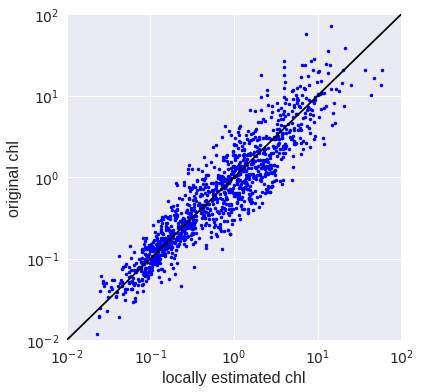

In [24]:
pl.figure(figsize=(6,6))
pl.plot(chl_train,y_train.values,'b.')
pl.yscale('log')
pl.ylim(1e-2,1e2)
pl.xlim(1e-2,1e2)
pl.xscale('log')
pl.plot([1e-2,1e2],[1e-2,1e2],'k')
pl.xlabel('locally estimated chl', fontsize=16)
pl.ylabel('original chl', fontsize=16);

In [30]:
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.01,transformer=True,
                           trigonometric=False,
                           p_crossover=0.6, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.2,
                           max_samples=0.9, verbose=1, comparison=True, 
                           parsimony_coefficient=0.01)
est_gp.fit(np.log(X_train), np.log(y_train+1e-6))

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.36    135.213743688        7    3.56726582945    3.96122008129     42.08s
   1     7.79    5.80759081951        7    3.54935895831    4.12238192154     39.97s
   2     7.81    8.92589459205       21    3.50671031636    4.36071257448     37.48s
   3     7.24    5.73058590888        8    3.43802437828    4.58798618128     34.80s
   4      6.2    5.72066717311        8    3.38519618616    5.11536451827     33.09s
   5     6.33     5.5205536159        9    3.41156771471    4.45717132729     30.52s
   6     6.79     5.2092726692        8      3.355123313    4.96517094263     28.10s
   7      7.5    5.29873168386        8    3.38405253642    4.70480793184     25.80s
   8     7.78    5.32099420256        8    3.37423986782    4.79312194923  

SymbolicRegressor(comparison=True, const_range=(-1.0, 1.0), generations=20,
         init_depth=(2, 6), init_method='half and half', max_samples=0.9,
         metric='mean absolute error', n_jobs=1, p_crossover=0.6,
         p_hoist_mutation=0.05, p_point_mutation=0.2, p_point_replace=0.05,
         p_subtree_mutation=0.1, parsimony_coefficient=0.01,
         population_size=5000, random_state=None, stopping_criteria=0.01,
         tournament_size=20, transformer=True, trigonometric=False,
         verbose=1)

In [31]:
print(est_gp._program)

mul(sub(X1, X4), neg(inv(0.696)))


In [ ]:
y_from_train = est_gp.predict(np.log(X_train))

In [ ]:
f,axs = pl.subplots(ncols=2, figsize=(10,6))
sb.regplot(np.log(y_from_train), np.log(y_train), ax=axs[0],)
sb.regplot(np.log(chl_train), np.log(y_train), ax=axs[1])

In [32]:
est_gp.score(X_test,y_test)

-0.18956266196600291

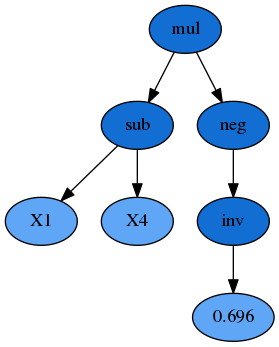

In [33]:
graph = pydotplus.graphviz.graph_from_dot_data(est_gp._program.export_graphviz())
Image(graph.create_png())